# Wage ARIMA Model - Training (1997-2020), Training (2021-2023)

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import gdown

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2. Load the dataset
# URL of the Google Drive file
url = 'https://drive.google.com/uc?id=1wjTiPLhi938Ro-jfjVHF0d_YPvsLaRc3'

# Download the file
output = 'data_wage.csv'
gdown.download(url, output, quiet=False)

# Check the content of the downloaded file to ensure it's a valid CSV
with open(output, 'r') as file:
    content = file.read()
    print("File content preview:")
    print(content[:500]) 

# Load the CSV file into a pandas DataFrame
try:
    data = pd.read_csv(output, delimiter=',')  
    print(data.head())
except pd.errors.ParserError as e:
    print("Error parsing CSV file:", e)

Downloading...
From: https://drive.google.com/uc?id=1wjTiPLhi938Ro-jfjVHF0d_YPvsLaRc3
To: d:\OneDrive (Personal)\OneDrive\~ TMU 2023\CIND 820 - Big Data Analytics Project\06 - Initial Results & Code (10%)\data_wage.csv
100%|██████████| 80.1M/80.1M [00:01<00:00, 48.1MB/s]


File content preview:
ref_date,geo,wages,type_of_work,sex,age_group,value,occupation_classification,noc,sex_binary,age_group_numeric,geo_code,date_ordinal,year,month
1997-01-01,newfoundland and labrador,average hourly wage rate,full-time employees,males,25 to 54 years,18.7,legislative and senior management occupations,00,1,1,210,729025,1997,1
1997-02-01,newfoundland and labrador,average hourly wage rate,full-time employees,males,25 to 54 years,18.48,legislative and senior management occupations,00,1,1,210,729056,1997
     ref_date                        geo                     wages  \
0  1997-01-01  newfoundland and labrador  average hourly wage rate   
1  1997-02-01  newfoundland and labrador  average hourly wage rate   
2  1997-03-01  newfoundland and labrador  average hourly wage rate   
3  1997-04-01  newfoundland and labrador  average hourly wage rate   
4  1997-05-01  newfoundland and labrador  average hourly wage rate   

          type_of_work    sex       age_group  value  \


In [3]:
# 3. Preprocess Data
# Convert 'ref_date' to datetime
data['ref_date'] = pd.to_datetime(data['ref_date'], format='%Y-%m-%d')

# Set 'ref_date' as index
data.set_index('ref_date', inplace=True)

# Ensure only numeric columns are included
numeric_cols = data.select_dtypes(include=[np.number]).columns
data_wage = data[numeric_cols]

# Aggregate data by year to reduce noise
data_annual = data_wage.resample('Y').mean()

# Select the 'value' column for ARIMA modeling
wage_rate = data_annual['value']

# Split the data into training and testing sets based on the date
train_data = wage_rate[wage_rate.index < '2021']
test_data = wage_rate[wage_rate.index >= '2021']

In [4]:
# 4. Define Cross-Validation Procedure
tscv = TimeSeriesSplit(n_splits=5)

In [5]:
# 5. Perform Cross-Validation
cv_mse_scores = []
for train_index, val_index in tscv.split(train_data):
    train_cv, val_cv = train_data.iloc[train_index], train_data.iloc[val_index]
    
    # Fit the ARIMA model
    model = ARIMA(train_cv, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=len(val_cv))
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(val_cv, forecast)
    cv_mse_scores.append(mse)

print('Cross-Validation Mean Squared Error:', np.mean(cv_mse_scores))

Cross-Validation Mean Squared Error: 0.3401539667034796


In [6]:
# 6. Train Final Model on Entire Training Set and Forecast on Test Set
final_model = ARIMA(train_data, order=(1, 1, 1))
final_model_fit = final_model.fit()

# Forecast
final_forecast = final_model_fit.forecast(steps=len(test_data))
forecast_index = test_data.index

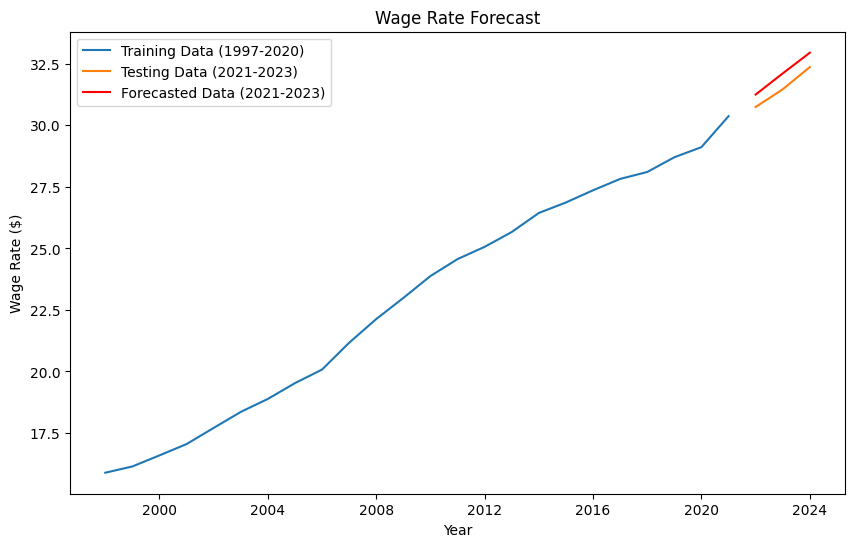

Final Model Mean Squared Error: 0.33815156017198467


In [7]:
# 7. Visualize the Data
# Visualize the Forecasted Data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data (1997-2020)')
plt.plot(test_data, label='Testing Data (2021-2023)')
plt.plot(forecast_index, final_forecast, label='Forecasted Data (2021-2023)', color='red')
plt.title('Wage Rate Forecast')
plt.xlabel('Year')
plt.ylabel('Wage Rate ($)')
plt.legend()
plt.show()

# Calculate Mean Squared Error for the final model
final_mse = mean_squared_error(test_data, final_forecast)
print('Final Model Mean Squared Error:', final_mse)
